# A-Phasen: Traffic Prediction & Optimization

Dieses Notebook erweitert die bisherigen Analysen und bringt die A-Phase (Modellierung) in eine kundenverständliche Form: wir beschreiben das Ziel, zeigen verständliche Visualisierungen der Daten, vergleichen mehrere Modelle und erklären die wichtigsten Ergebnisse so, dass auch fachfremde Stakeholder den Mehrwert erkennen.

Inhaltsübersicht
- A1: Problemdefinition & Ziel
- A2: Verständliche EDA (wichtige Grafiken mit Interpretation)
- A3: Modellvergleich (Baselines, ML-Modelle)
- A4: Kurzbeschreibung der nächsten Schritte (Deployment / Monitoring)

Hinweis: Die Zellen unten können nacheinander ausgeführt werden; die wichtigen Grafiken werden in `reports/figures/` gespeichert, falls vorhanden.

## A1 – Problemdefinition (kundenfreundlich)

Ziel: Wir möchten das stündliche Verkehrsaufkommen (`y`) vorhersagen. Das ermöglicht später Optimierungen wie adaptive Ampelsteuerung oder Verkehrslenkung.

Warum das wichtig ist (in 1–2 Sätzen): Mit zuverlässigen Kurzfrist-Prognosen können Steuerungsmaßnahmen proaktiv ausgelöst werden (z. B. kurzfristige Grünphasen), was Wartezeiten reduziert und den Verkehrsfluss verbessert.

Kernaussagen, die wir im Notebook beantworten:
- Wie sieht das Verkehrsaufkommen zeitlich aus (Tages-/Wochen-Muster)?
- Lässt sich ein einfaches Modell (Baseline) durch ML‑Modelle signifikant verbessern?
- Welche Features (z. B. Stunde, Wochentag, Lags) sind besonders wichtig?

## A1.1 – Bibliotheken

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_theme(style="whitegrid")
print("✅ Bibliotheken geladen")

✅ Bibliotheken geladen


## A1.2 – Daten laden

Wir laden die bereitgestellte Datei `data/df_final.csv`. Erwartet werden mindestens:
- Zeitspalte `ds` oder `timestamp` (Datetime)
- Zielspalte `y` oder `target`

Wenn die Zeitspalte anders heißt, wird sie automatisch erkannt (z.B. `timestamp`).

In [17]:
# Pfade
ROOT = Path.cwd()
DATA_PATH = ROOT / "data" / "df_final.csv"
FIG_DIR = ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Einfache Ladefunktion
_df = pd.read_csv(DATA_PATH)

# Rename falls nötig
if "timestamp" in _df.columns and "ds" not in _df.columns:
    _df = _df.rename(columns={"timestamp": "ds"})

# Erkenne Zeitspalte
if "ds" in _df.columns:
    _df["ds"] = pd.to_datetime(_df["ds"])
else:
    # fallback: suche nach einem Datums-ähnlichen Namen
    for c in _df.columns:
        if "time" in c.lower() or "date" in c.lower():
            _df[c] = pd.to_datetime(_df[c])
            _df = _df.rename(columns={c: "ds"})
            break

# Zielspalte
if "y" in _df.columns:
    target_col = "y"
elif "target" in _df.columns:
    target_col = "target"
else:
    # suche numerische Spalte, die plausibel ist
    num_cols = _df.select_dtypes(include=["number"]).columns.tolist()
    # entferne id/spalten ohne Varianz
    num_cols = [c for c in num_cols if _df[c].nunique() > 1]
    if len(num_cols) == 1:
        target_col = num_cols[0]
    else:
        raise ValueError("Keine eindeutige Zielspalte gefunden. Bitte Spalte 'y' oder 'target' setzen.")

print(f"Zeitspalte: ds; Zielspalte: {target_col}")
_df = _df.sort_values("ds").reset_index(drop=True)
display(_df.head())

Zeitspalte: ds; Zielspalte: y


,ds,y,hour,hour_sin,hour_cos,weekday,is_weekend,month,weather,lag_1,lag_24,rolling_mean_3h,rolling_mean_12h
0,2023-01-02 00:00:00,50,0,0.000000,1.000000,0,0,1,sunny,27.0,35.0,32.000000,36.333333
1,2023-01-02 01:00:00,48,1,0.258819,0.965926,0,0,1,cloudy,50.0,22.0,35.666667,38.583333
2,2023-01-02 02:00:00,58,2,0.500000,0.866025,0,0,1,sunny,48.0,33.0,41.666667,40.083333
3,2023-01-02 03:00:00,50,3,0.707107,0.707107,0,0,1,cloudy,58.0,25.0,52.000000,42.000000
4,2023-01-02 04:00:00,35,4,0.866025,0.500000,0,0,1,cloudy,50.0,30.0,52.000000,43.416667


## A2 – Verstehende EDA (grafisch & verständlich)

Ziel: Visualisierungen, die einem Kunden schnell sagen, wie sich Last über Tag/Woche verteilt und ob Ausreißer/Saisonalität sichtbar sind.

Wir erzeugen diese Grafiken:
- Zeitreihe (kompakte Ansicht über den gesamten Zeitraum)
- Detaillierte Ansicht der letzten N Tagen (z. B. 14 Tage)
- Heatmap: durchschnittliches Verkehrsaufkommen Stunde × Wochentag
- Boxplot: Verteilung pro Stunde (zeigt Peak-Zeiten)
- Histogramm der Zielverteilung

Zu jeder Grafik gibt es eine kurze Interpretation (Markdown-Ausgabe).

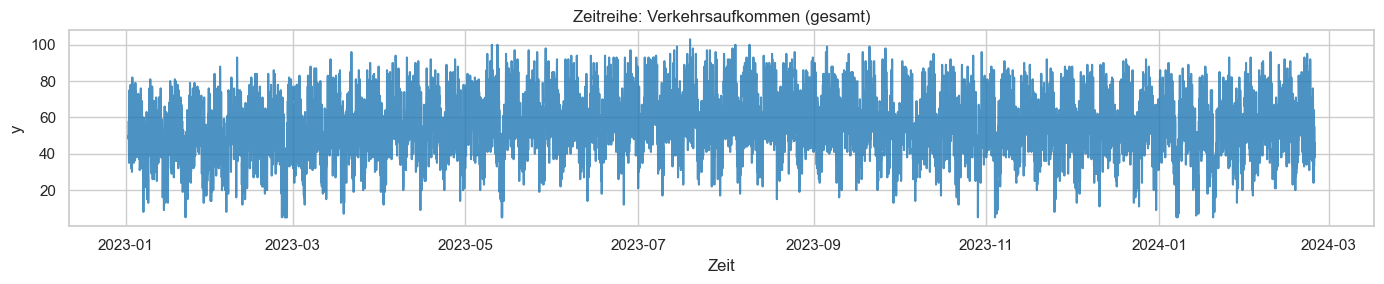

In [18]:
 # Zeitreihe (gesamt)
plt.figure(figsize=(14,3))
plt.plot(_df["ds"], _df[target_col], color="tab:blue", alpha=0.8)
plt.title("Zeitreihe: Verkehrsaufkommen (gesamt)")
plt.xlabel("Zeit")
plt.ylabel(target_col)
plt.tight_layout()
plt.savefig(FIG_DIR / "eda_timeseries_full.png", dpi=150)
plt.show()

### Interpretation der Zeitreihe: Verkehrsaufkommen (gesamt)

Die Zeitreihe zeigt das gesamte Verkehrsaufkommen von Anfang 2023 bis Anfang 2024.

#### 1. Trend
- Über den Gesamtzeitraum ist **kein klarer starker langfristiger Aufwärts- oder Abwärtstrend** erkennbar.
- Es scheint jedoch eine **leichte Niveauerhöhung bis etwa Mitte 2023** vorzuliegen.
- Gegen Ende 2023 bzw. Anfang 2024 wirkt das Niveau etwas stabiler bzw. minimal rückläufig.

→ Insgesamt deutet dies auf ein relativ stabiles Verkehrsaufkommen mit leichten mittelfristigen Schwankungen hin.

---

#### 2. Saisonalität
- Es sind **regelmäßige, stark wiederkehrende Schwankungen** sichtbar.
- Die hohe Frequenz der Ausschläge spricht für eine **ausgeprägte tägliche bzw. wöchentliche Saisonalität**.
- Typisch wären:
  - Höhere Werte an Werktagen
  - Niedrigere Werte an Wochenenden
  - Mehrere Peaks pro Tag (Berufsverkehr)

→ Die Daten zeigen eine klare periodische Struktur.

---

#### 3. Volatilität
- Die Schwankungsbreite ist relativ hoch (Werte grob zwischen ca. 10 und 100).
- Die Varianz wirkt über den Zeitraum hinweg **relativ konstant**, es ist keine starke Heteroskedastizität erkennbar.

→ Das Verkehrsaufkommen unterliegt starken, aber stabilen Schwankungen.

---

#### 4. Ausreißer
- Einzelne sehr niedrige Werte (nahe 0–10) sowie sehr hohe Peaks (>100) sind sichtbar.
- Diese könnten verursacht sein durch:
  - Feiertage
  - Extreme Wetterbedingungen
  - Großveranstaltungen
  - Messfehler oder Datenlücken

→ Eine gesonderte Ausreißeranalyse wäre sinnvoll.

---

### Gesamtfazit

Die Zeitreihe ist geprägt von:

- ✔ Starker kurzfristiger Saisonalität
- ✔ Relativ stabilem langfristigem Niveau
- ✔ Hoher, aber konstanter Schwankungsintensität
- ✔ Vereinzelten Ausreißern

Für die Modellierung empfiehlt sich ein Verfahren, das **Saisonalität explizit berücksichtigt** (z. B. SARIMA oder Prophet).
Eine Dekomposition in Trend-, Saison- und Restkomponente wäre der nächste sinnvolle Analyseschritt.

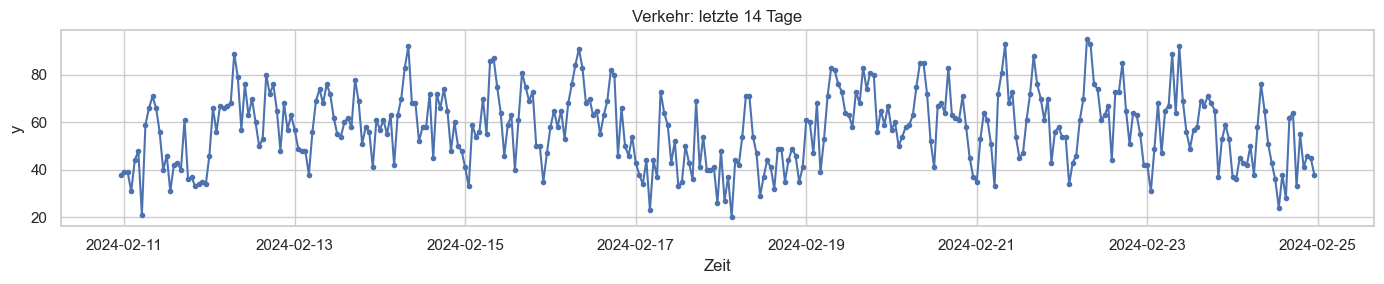

In [19]:
# Detailansicht: letzte 14 Tage
N_DAYS = 14
recent = _df[_df["ds"] >= (_df["ds"].max() - pd.Timedelta(days=N_DAYS))]
plt.figure(figsize=(14,3))
plt.plot(recent["ds"], recent[target_col], marker="o", ms=3)
plt.title(f"Verkehr: letzte {N_DAYS} Tage")
plt.xlabel("Zeit")
plt.ylabel(target_col)
plt.tight_layout()
plt.savefig(FIG_DIR / "eda_timeseries_recent.png", dpi=150)
plt.show()

### Interpretation: Detailansicht der letzten 14 Tage

Die Abbildung zeigt das Verkehrsaufkommen vom **11.02.2024 bis 25.02.2024** in hoher zeitlicher Auflösung.

---

### 1. Ausgeprägte Tagesstruktur

Es ist ein sehr klares, sich täglich wiederholendes Muster erkennbar:

- Mehrere Peaks pro Tag (vermutlich Morgen- und Abendverkehr)
- Niedrigere Werte in den Nachtstunden
- Relativ konstante zeitliche Lage der Peaks

→ Dies bestätigt eine **starke tägliche Saisonalität**.

---

### 2. Unterschiedliche Tagesniveaus (Wochenstruktur)

Zwischen einzelnen Tagen sind Niveauunterschiede sichtbar:

- Einige Tage zeigen höhere Maximalwerte (über 80–90).
- Andere Tage bleiben insgesamt auf niedrigerem Niveau.

→ Dies deutet auf einen **Wochentagseffekt** hin (Werktage vs. Wochenende).

Besonders um den 17.–18.02. sind niedrigere Gesamtwerte erkennbar, was auf ein Wochenende hindeuten könnte.

---

### 3. Schwankungsbreite & Volatilität

- Werte bewegen sich grob zwischen **20 und 95**.
- Innerhalb eines Tages sind teils starke kurzfristige Schwankungen sichtbar.
- Die Varianz wirkt jedoch insgesamt stabil (keine zunehmende Streuung).

→ Das System zeigt dynamische, aber kontrollierte Schwankungen.

---

### 4. Mögliche Ausreißer

Einzelne auffällige Punkte:
- Sehr hohe Peaks (>90)
- Sehr niedrige Einbrüche (~20)

Mögliche Ursachen:
- Verkehrsstörungen
- Wetterbedingungen
- Lokale Events
- Feiertage
- Messartefakte

Eine statistische Ausreißeranalyse (z. B. IQR oder Z-Score) könnte diese objektiv identifizieren.

---

## Gesamtfazit

Die Detailansicht zeigt klar:

- ✔ Starke tägliche Periodizität
- ✔ Hinweise auf Wochenstruktur
- ✔ Moderate, stabile Volatilität
- ✔ Einzelne potenzielle Ausreißer

Für eine Prognose bedeutet das:

- Ein Modell mit **mehrfacher Saisonalität (Tag + Woche)** ist geeignet.
- Eine reine Trendmodellierung wäre unzureichend.
- Externe Einflussfaktoren könnten die Prognosequalität weiter verbessern.

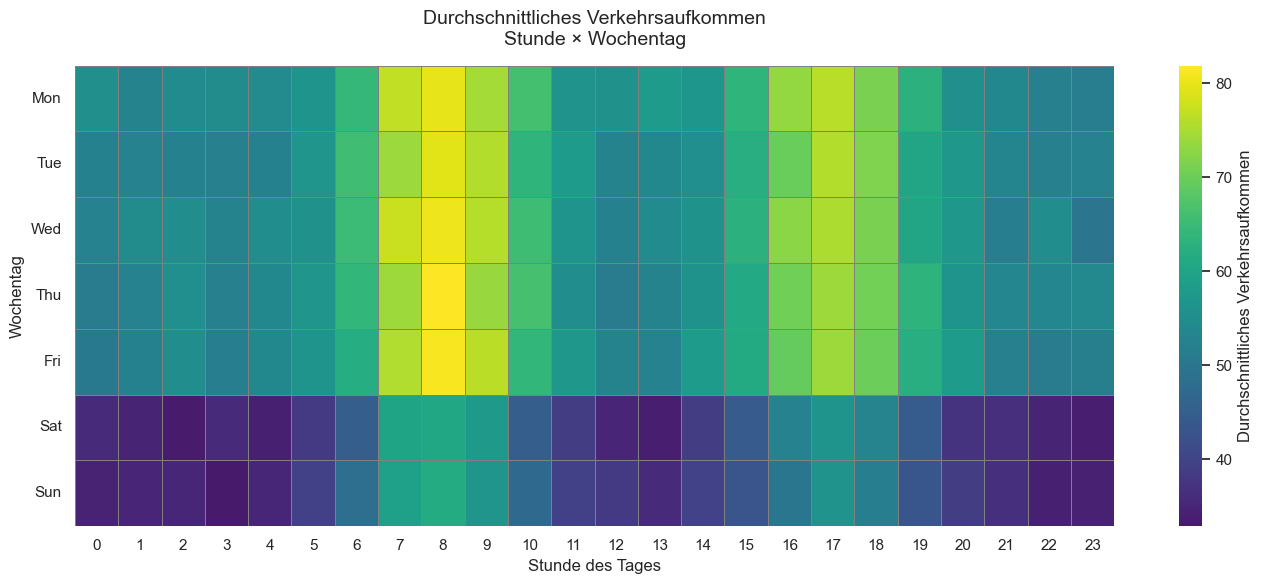

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Stunden & Wochentag extrahieren
_df["hour"] = _df["ds"].dt.hour
_df["weekday"] = _df["ds"].dt.weekday

# Pivot-Tabelle (Wochentag als Zeilen, Stunde als Spalten)
pivot = (
    _df.groupby(["weekday", "hour"])[target_col]
    .mean()
    .unstack(level=1)
)

# Wochentagsnamen
weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
pivot.index = weekday_labels

# Plot
plt.figure(figsize=(14,6))
sns.set_style("white")

ax = sns.heatmap(
    pivot,
    cmap="viridis",
    center=pivot.values.mean(),
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Durchschnittliches Verkehrsaufkommen"},
    annot=False  # auf True setzen wenn Zahlen gewünscht sind
)

plt.title("Durchschnittliches Verkehrsaufkommen\nStunde × Wochentag", fontsize=14, pad=15)
plt.xlabel("Stunde des Tages", fontsize=12)
plt.ylabel("Wochentag", fontsize=12)

plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(FIG_DIR / "eda_heatmap_hour_weekday_beautiful.png", dpi=150)
plt.show()

### Interpretation der Heatmap: Durchschnittliches Verkehrsaufkommen (Stunde × Wochentag)

Die Heatmap zeigt das **durchschnittliche Verkehrsaufkommen** in Abhängigkeit von **Stunde des Tages** (x-Achse) und **Wochentag** (y-Achse). Helle Farben stehen für hohe Werte, dunklere Farben für geringere Werte.

---

## 1. Deutliche Tagesstruktur (intraday pattern)

Es sind klar zwei typische Hochphasen pro Werktag erkennbar:

- **Morgenpeak (ca. 7–9 Uhr)**
- **Abendpeak (ca. 16–18 Uhr)**

Diese Struktur ist konsistent von Montag bis Freitag sichtbar und entspricht dem klassischen Berufsverkehr.

Nachts (0–5 Uhr) ist das Verkehrsaufkommen durchgehend niedrig.

→ Es liegt eine **starke tägliche Saisonalität** vor.

---

## 2. Unterschied zwischen Werktagen und Wochenende

Ein klarer Kontrast zeigt sich zwischen:

### Werktagen (Mo–Fr)
- Höhere Peaks
- Deutlich ausgeprägte Pendlerstruktur
- Höheres Gesamtniveau

### Wochenende (Sa–So)
- Insgesamt geringeres Verkehrsaufkommen
- Weniger ausgeprägte Morgenpeaks
- Gleichmäßigere Verteilung über den Tag

→ Dies weist auf eine **ausgeprägte Wochen-Saisonalität** hin.

---

## 3. Stabilität der Muster

Die Farbverläufe sind über mehrere Werktage hinweg sehr ähnlich.
Das bedeutet:

- Hohe strukturelle Stabilität
- Gute Vorhersagbarkeit
- Systematisches, nicht zufälliges Verhalten

→ Das Verkehrsaufkommen folgt klaren, wiederkehrenden Mustern.

---

## 4. Interpretation für Modellierung

Die Heatmap zeigt:

✔ Mehrfache Saisonalität (Tag + Woche)
✔ Regelmäßige Pendlerdynamik
✔ Niedrigere Wochenendniveaus
✔ Kaum unstrukturierte Zufallsmuster

Für Prognosemodelle bedeutet das:

- Ein Modell sollte **tägliche UND wöchentliche Saisonalität** berücksichtigen.
- Dummy-Variablen für Wochentage oder Fourier-Terme sind sinnvoll.
- Modelle wie **SARIMA, Prophet oder TBATS** sind gut geeignet.
- Ein einfaches lineares Trendmodell wäre nicht ausreichend.

---

## Gesamtfazit

Die Heatmap bestätigt, dass das Verkehrsaufkommen stark durch:

- Arbeits- und Pendelverhalten
- Tageszeit
- Wochenstruktur

bestimmt wird.

Die Muster sind stabil, klar erkennbar und modellierbar – eine sehr gute Grundlage für eine belastbare Zeitreihenprognose.

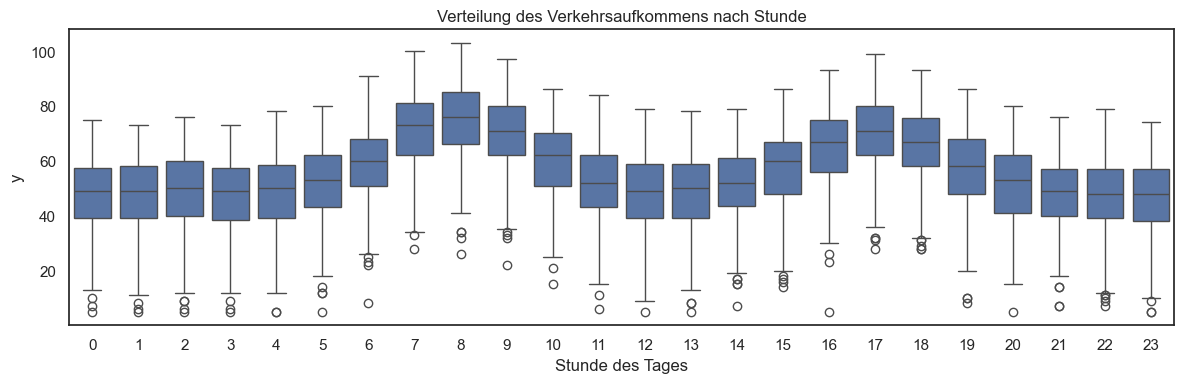

Interpretation: Der Boxplot zeigt, in welchen Stunden die Verteilung breit (hohe Varianz) ist und wo klare Peaks liegen.


In [21]:
# Boxplot pro Stunde (Verteilung)
plt.figure(figsize=(12,4))
sns.boxplot(x=_df["hour"], y=_df[target_col])
plt.title("Verteilung des Verkehrsaufkommens nach Stunde")
plt.xlabel("Stunde des Tages")
plt.ylabel(target_col)
plt.tight_layout()
plt.savefig(FIG_DIR / "eda_boxplot_by_hour.png", dpi=150)
plt.show()

print("Interpretation: Der Boxplot zeigt, in welchen Stunden die Verteilung breit (hohe Varianz) ist und wo klare Peaks liegen.")

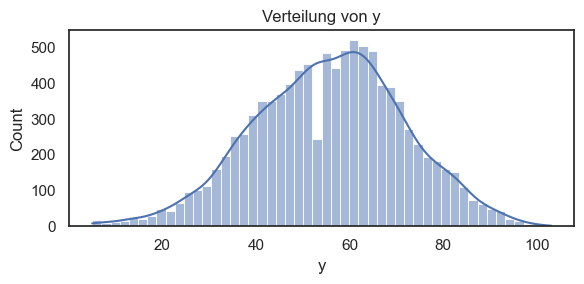

Interpretation: Das Histogramm gibt Hinweise auf Schiefe/Outlier; bei starker Schiefe kann eine Transformation (z.B. Log) sinnvoll sein.


In [22]:
# Histogramm Zielverteilung
plt.figure(figsize=(6,3))
sns.histplot(_df[target_col], bins=50, kde=True)
plt.title("Verteilung von y")
plt.tight_layout()
plt.savefig(FIG_DIR / "eda_hist_y.png", dpi=150)
plt.show()

print("Interpretation: Das Histogramm gibt Hinweise auf Schiefe/Outlier; bei starker Schiefe kann eine Transformation (z.B. Log) sinnvoll sein.")

## A3 – Feature Engineering (kurz erklärt)

Wir erzeugen einfache, robuste Features, die für viele Zeitreihen funktionieren:
- hour, weekday
- lag_1 (y(t-1)) und lag_24 (y(t-24)) — fangen kurzfristige Autokorrelation / Tagesmuster ein
- rolling mean (3h, 24h)

Diese Features sind interpretable und leicht umzusetzen in Produktion.

In [23]:
# Feature Engineering
df = _df.copy()
df["lag_1"] = df[target_col].shift(1)
df["lag_24"] = df[target_col].shift(24)
df["rmean_3"] = df[target_col].rolling(window=3).mean()
df["rmean_24"] = df[target_col].rolling(window=24).mean()

df = df.dropna().reset_index(drop=True)
print("Features erzeugt. Datensätze nach dropna:", df.shape)
display(df.head())

Features erzeugt. Datensätze nach dropna: (10032, 15)


,ds,y,hour,hour_sin,hour_cos,weekday,is_weekend,month,weather,lag_1,lag_24,rolling_mean_3h,rolling_mean_12h,rmean_3,rmean_24
0,2023-01-03 00:00:00,34,0,0.000000,1.000000,1,0,1,cloudy,32.0,50.0,43.333333,53.416667,37.666667,53.083333
1,2023-01-03 01:00:00,49,1,0.258819,0.965926,1,0,1,sunny,34.0,48.0,37.666667,52.000000,38.333333,53.125000
2,2023-01-03 02:00:00,37,2,0.500000,0.866025,1,0,1,rainy,49.0,58.0,38.333333,51.083333,40.000000,52.250000
3,2023-01-03 03:00:00,44,3,0.707107,0.707107,1,0,1,cloudy,37.0,50.0,40.000000,49.916667,43.333333,52.000000
4,2023-01-03 04:00:00,36,4,0.866025,0.500000,1,0,1,rainy,44.0,35.0,43.333333,49.000000,39.000000,52.041667


## A4 – Modellvergleich (kundenfreundlich)

Wir vergleichen eine einfache Lineare Baseline und mehrere stärkere Modelle. Für Stakeholder wichtig:
- Wir zeigen die Metriken (MAE, RMSE, R2) in einer Tabelle
- Zusätzlich visualisieren wir: Barplot der RMSEs und Actual vs Pred für das beste Modell

Metriken (kurz erklärt):
- MAE: mittlerer absoluter Fehler (einfach interpretierbar)
- RMSE: stärker von Ausreißern beeinflusst (wichtig, wenn große Fehler besonders schaden)
- R²: Anteil der erklärten Varianz

In [24]:
# Daten aufteilen (chronologisch), 80/20
TEST_FRACTION = 0.2
split_idx = int((1 - TEST_FRACTION) * len(df))

features = ["hour", "weekday", "lag_1", "lag_24", "rmean_3", "rmean_24"]
X = df[features]
y = df[target_col]

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (8025, 6) Test shape: (2007, 6)


,Model,MAE,RMSE,R2
3,GradientBoosting,5.226693,6.583734,0.831768
2,RandomForest,5.463777,6.935528,0.813310
0,Linear,6.264157,7.795755,0.764126
1,Ridge,6.264159,7.795755,0.764126


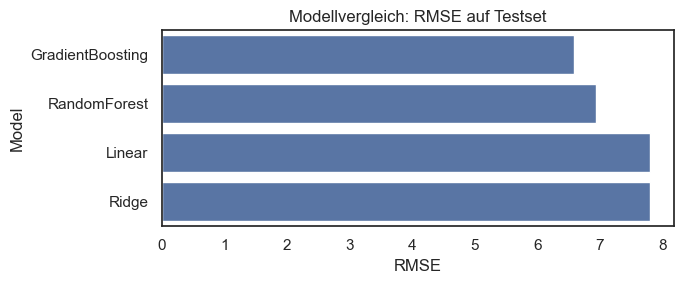

Interpretation: Kleinere RMSE ist besser; wir wählen das Modell mit niedrigstem RMSE als Favoriten für weitere Optimierung.


In [25]:
# Modelle definieren
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results.append((name, mae, rmse, r2, model, preds))

res_df = pd.DataFrame([{"Model": r[0], "MAE": r[1], "RMSE": r[2], "R2": r[3]} for r in results])
res_df = res_df.sort_values("RMSE")
display(res_df)

# Barplot RMSE
plt.figure(figsize=(7,3))
sns.barplot(x="RMSE", y="Model", data=res_df)
plt.title("Modellvergleich: RMSE auf Testset")
plt.tight_layout()
plt.savefig(FIG_DIR / "model_compare_rmse.png", dpi=150)
plt.show()

print("Interpretation: Kleinere RMSE ist besser; wir wählen das Modell mit niedrigstem RMSE als Favoriten für weitere Optimierung.")

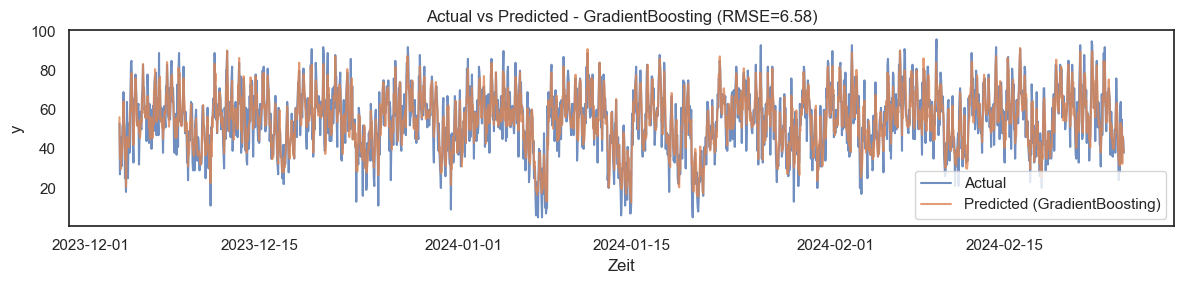

Interpretation: Hier sehen Stakeholder, wie gut die Vorhersage den tatsächlichen Verlauf trifft; besonders wichtig ist die Lage/Amplitude der Peaks.


In [26]:
# Actual vs Pred für bestes Modell
best_name, best_mae, best_rmse, best_r2 = res_df.iloc[0]["Model"], res_df.iloc[0]["MAE"], res_df.iloc[0]["RMSE"], res_df.iloc[0]["R2"]
# finde preds des besten
best_entry = [r for r in results if r[0] == best_name][0]
best_model = best_entry[4]
best_preds = best_entry[5]

plt.figure(figsize=(12,3))
plt.plot(df["ds"].iloc[split_idx:], y_test, label="Actual", alpha=0.8)
plt.plot(df["ds"].iloc[split_idx:], best_preds, label=f"Predicted ({best_name})", alpha=0.8)
plt.xlabel("Zeit")
plt.ylabel(target_col)
plt.title(f"Actual vs Predicted - {best_name} (RMSE={best_rmse:.2f})")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "actual_vs_pred_best.png", dpi=150)
plt.show()

print("Interpretation: Hier sehen Stakeholder, wie gut die Vorhersage den tatsächlichen Verlauf trifft; besonders wichtig ist die Lage/Amplitude der Peaks.")

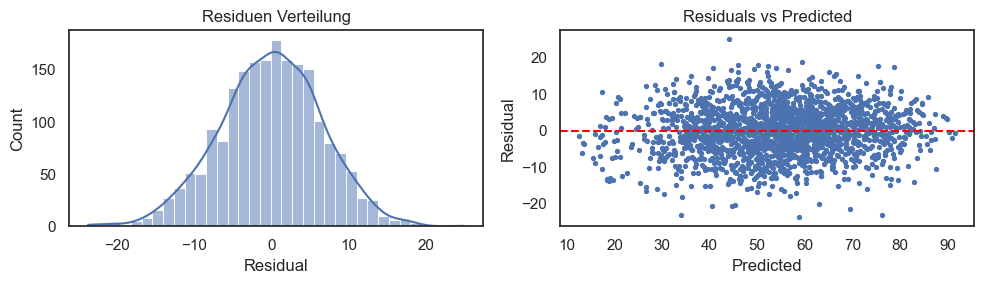

Interpretation: Residuen sollten möglichst symmetrisch um 0 liegen; Abhängigkeiten oder Muster deuten auf Modell-Bias hin.


In [27]:
# Residual-Analyse
residuals = y_test.values - best_preds
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.histplot(residuals, kde=True)
plt.title("Residuen Verteilung")
plt.xlabel("Residual")

plt.subplot(1,2,2)
plt.scatter(best_preds, residuals, s=8)
plt.axhline(0, color='red', ls='--')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.savefig(FIG_DIR / "residuals_analysis.png", dpi=150)
plt.show()

print("Interpretation: Residuen sollten möglichst symmetrisch um 0 liegen; Abhängigkeiten oder Muster deuten auf Modell-Bias hin.")

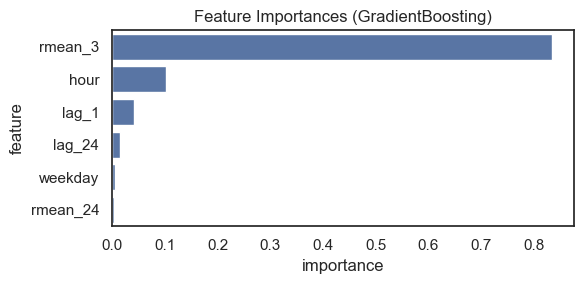

Interpretation: Wichtigste Merkmale können direkt für Regeln/Trigger in der Optimierungslogik genutzt werden.


In [28]:
# Feature Importances (für Tree-Modelle)
if hasattr(best_model, "feature_importances_"):
    fi = best_model.feature_importances_
    feat_names = features
    fi_df = pd.DataFrame({"feature": feat_names, "importance": fi}).sort_values("importance", ascending=False)
    plt.figure(figsize=(6,3))
    sns.barplot(x="importance", y="feature", data=fi_df)
    plt.title(f"Feature Importances ({best_name})")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "feature_importances_best.png", dpi=150)
    plt.show()
    print("Interpretation: Wichtigste Merkmale können direkt für Regeln/Trigger in der Optimierungslogik genutzt werden.")
else:
    print("Kein feature_importances_ vorhanden für bestes Modell (z.B. bei Linearmodellen).")

## A5 – Handlungsempfehlungen / Nächste Schritte (kurz & kundengerecht)

1) Wenn das Modell zuverlässig ist (RMSE besser als Baseline), Produktionstauglichkeit prüfen: Latenz, Modellgröße, Daten-Pipeline.
2) Monitoring: Tägliche/bei jedem Lauf Kontrolle der Metriken + Drift-Erkennung (Feature-Distributionen).
3) Deployment: kleines API (Flask/FASTAPI) oder direkte Integration in Steuerungslogik (z. B. Ampelcontroller) für Live‑Predictions.
4) Optional: Fortgeschrittenes Tuning (Optuna) und Explainability (SHAP) für kritische Entscheidungen.

Abschluss: Dieses Notebook ist so aufgebaut, dass es als Präsentationsdokument für Kunden dienen kann: klare Grafiken, kurze Interpretationen und nachvollziehbare Metriken.